# Jigsaw Unintended Bias in Toxicity Classification

<br></br>
The provided data has several additional __toxicity__ subtype attributes, but this is not required in the competition. These columns included:

- severe_toxicity
- obscene
- threat
- insult
- identity_attack
- sexual_explicit

<br></br>
Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. __The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.__


* __male__
* __female__
* transgender
* other_gender
* heterosexual
* __homosexual_gay_or_lesbian__
* bisexual
* other_sexual_orientation
* __christian__
* __jewish__
* __muslim__
* hindu
* buddhist
* atheist
* other_religion
* __black__
* __white__
* asian
* latino
* other_race_or_ethnicity
* physical_disability
* intellectual_or_learning_disability
* __psychiatric_or_mental_illness__
* other_disability

<br></br>

_Note that the data contains different comments that can have the exact same text. Different comments that have the same text may have been labeled with different targets or subgroups._

<br></br>

In this __part one__ of the series, I will have a look at the data set, conduct the exploratory analysis on the text data, and then do some word cloud visualization on the toxic vs. non-toxic comments.

<br></br>

### Labelling Schema

To obtain the toxicity labels, each comment was shown to up to 10 annotators*. Annotators were asked to: "Rate the toxicity of this comment"

* Very Toxic (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion or give up on sharing your perspective)
* Toxic (a rude, disrespectful, or unreasonable comment that is somewhat likely to make you leave a discussion or give up on sharing your perspective)
* Hard to Say
* Not Toxic

These ratings were then aggregated with the target value representing the fraction of annotations that annotations fell within the former two categories.

<br></br>
The distributions of labels and subgroup between Train and Test can be __assumed to be similar__, but not exact.


In [1]:
import os
import gc
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import gensim
from gensim.utils import simple_preprocess
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image

pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')
tqdm.pandas()

C:\Users\n.satsawat\Anaconda3_\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Global variables definition

Declare the global variables here.

In [2]:
SEED = 5012
PATH = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

Observe the file in _data_ directory

In [3]:
os.listdir("../data")

['sample_submission.csv', 'test.csv', 'train.csv']

There are 3 files in __data__ directory. Show some sample rows from files.

In [4]:
display(pd.read_csv("../data/train.csv", nrows=5))
display(pd.read_csv("../data/test.csv", nrows=5))

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [5]:
def read_csv_(data_path='../data/train.csv', head=5):
    '''
    Function to read the data from csv and print several information regarding to the data
    @Args:
       data_path: The absolute path to the file, including the file name and extensions 
                  (default: '../data/train.csv')
       head: the top observations to print; use 0 to ignore (default: 5)
       
    Return:
       The pandas dataframe of the read-in data
    '''
    df = pd.read_csv(data_path)
    _dtypes = df.columns.to_series().groupby(df.dtypes).groups
    print("Read in %s, the data contains %s observations with %s features." % \
          (data_path, df.shape[0], df.shape[1]))
    print("The data types are %s" % {k.name: v for k, v in _dtypes.items()})    
    if head > 0:
        print("Showing top %s observation(s)" % head)
        display(df.head(head))
    
    return df


def get_missing_values(df, 
                       return_missing_df_flag=False):
    '''
    Function to explore how many missing values (NaN) in the pandas
    @Args:
       df: pandas dataframe
       return_missing_df_flag: The boolean flag to return the missing pandas or not
       
    Return:
       Depends on the boolean flag; it will return the missing data table
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("There are %s columns that have missing values" % str(mis_val_table_ren_columns.shape[0]))
    if return_missing_df_flag:
        return mis_val_table_ren_columns




In [6]:
train_df = read_csv_('../data/train.csv')
test_df = read_csv_('../data/test.csv')

Read in ../data/train.csv, the data contains 1804874 observations with 45 features.
The data types are {'int64': Index(['id', 'publication_id', 'article_id', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object'), 'float64': Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult',
       'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist',
       'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'parent_id',
       'sexual_explicit'],
      dtype='object'), 'object': Index(['comment_text', 'created_date', 'rating'], dtype='object')}
Showing top 5 observation(s)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


Read in ../data/test.csv, the data contains 97320 observations with 2 features.
The data types are {'int64': Index(['id'], dtype='object'), 'object': Index(['comment_text'], dtype='object')}
Showing top 5 observation(s)


,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [7]:
get_missing_values(train_df, return_missing_df_flag=True)

There are 25 columns that have missing values


,Missing Values,% of Total Values
asian,1399744,77.6
male,1399744,77.6
white,1399744,77.6
transgender,1399744,77.6
psychiatric_or_mental_illness,1399744,77.6
physical_disability,1399744,77.6
other_sexual_orientation,1399744,77.6
other_religion,1399744,77.6
other_race_or_ethnicity,1399744,77.6
other_gender,1399744,77.6


In [8]:
get_missing_values(test_df, return_missing_df_flag=True)

There are 0 columns that have missing values


,Missing Values,% of Total Values


### Remove unused columns

As per mentioned above, several columns are not part of prediction. Let's drop these features.


In [9]:
train_df.drop(['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
             inplace=True, axis=1)
display(train_df.head(5))

,id,target,comment_text,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,4,47


In [10]:
train_df.drop(['transgender', 'other_gender', 'heterosexual', 'bisexual', 'other_sexual_orientation', 
               'hindu','buddhist', 'atheist', 'other_religion', 'asian', 'latino', 
               'other_race_or_ethnicity', 'physical_disability', 
               'intellectual_or_learning_disability', 'other_disability'],
             inplace=True, axis=1)
display(train_df.head(3))

,id,target,comment_text,black,christian,female,homosexual_gay_or_lesbian,jewish,male,muslim,psychiatric_or_mental_illness,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0,4


### Exploratory Data Analysis

First, let's dive onto the target variables and display their distributions on the data. We know that the range of the target is from 0.0 - 1.0. Divide them onto 10 bins (scale of 0.1 each) and plot its histogram.

___Finding___:

- The major distribution of toxicity score is mainly on 0.0-0.1 range.
- There is slightly increasing of score range of 0.2 and 0.3 from range of 0.1 and 0.2 (roughly 0.5%). This may have some interesting patterns which differed between these two.
- With this range, the toxicity comment will be toward __non-toxic__ class, hence our classifier will be misclassified a lot of comments, if not dealing with this imbalanced data properly.

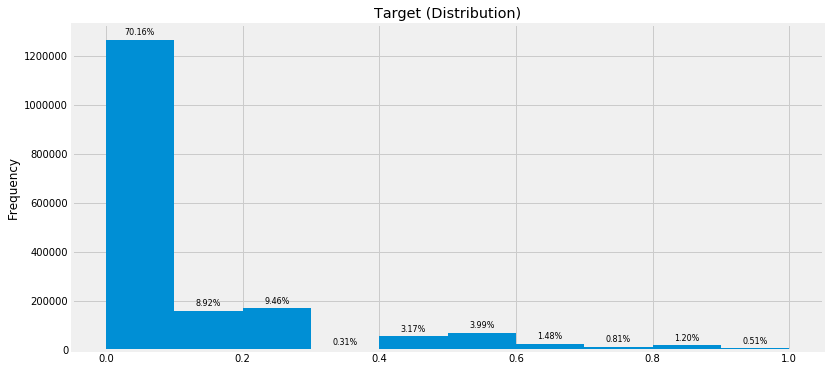

In [11]:
plt.figure(figsize=(12,6))
plot = train_df.target.plot(kind='hist',bins=10)

ax = plot.axes

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / train_df.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
plt.title('Target (Distribution)')
plt.show();

As mentioned, in the [data page](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data), the __toxic__ (positive) class will be considered when `target >= 0.5`.

- Using this notion to binarize the target column.

In [12]:
train_df['toxic'] = train_df['target'].progress_apply(lambda x: 1 if x >= 0.5 else 0)
train_df.loc[:, ['id', 'comment_text', 'target', 'toxic']].head(10)

100%|███████████████████████████████████████████████████████████████████| 1804874/1804874 [00:01<00:00, 1043386.74it/s]


,id,comment_text,target,toxic
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0
1,59849,Thank you!! This would make my life a lot less...,0.000000,0
2,59852,This is such an urgent design problem; kudos t...,0.000000,0
3,59855,Is this something I'll be able to install on m...,0.000000,0
4,59856,haha you guys are a bunch of losers.,0.893617,1
5,59859,ur a sh*tty comment.,0.666667,1
6,59861,hahahahahahahahhha suck it.,0.457627,0
7,59863,FFFFUUUUUUUUUUUUUUU,0.000000,0
8,239575,The ranchers seem motivated by mostly by greed...,0.000000,0
9,239576,It was a great show. Not a combo I'd of expect...,0.000000,0


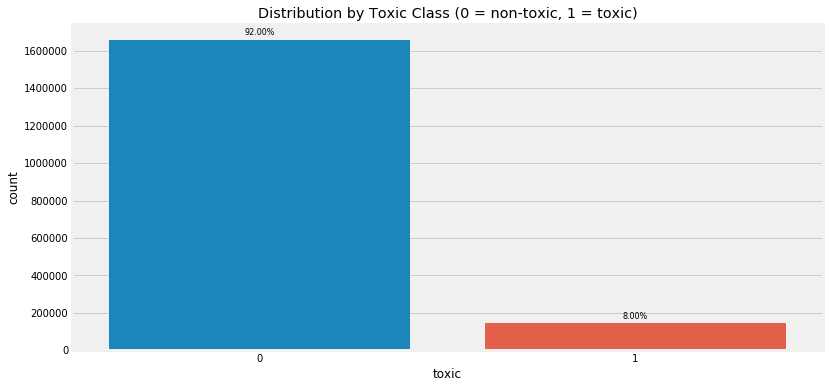

In [13]:
plt.figure(figsize=(12,6))
plot = sns.countplot(x='toxic', data=train_df)

ax = plot.axes

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / train_df.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
plt.title('Distribution by Toxic Class (0 = non-toxic, 1 = toxic)')
plt.show();

Now, we are dealing with very imbalanced data (92 vs. 8%)

__The main show: Text Comment__. Because this task is toxicity classification, which is the Machine Learning (ML) task in the form of _Natural Language Processing (__NLP__)_. 

<br></br>

To better visualize and observe the comments, there are several steps and approaches to do so. In this initial step, the punctuation and stop-words will remained un-processed.

- Add `comment_char_count` column, which will count all of the characters in the comment.
- Add `comment_word_count` column, which will count the words in the comment.

These two processes will be done to both __train__ and __test__ data.

In [14]:
train_df['comment_char_count'] = train_df.comment_text.progress_apply(len)
test_df['comment_char_count'] = test_df.comment_text.progress_apply(len)

100%|████████████████████████████████████████████████████████████████████████| 97320/97320 [00:00<00:00, 761327.72it/s]


Compare the character count between these two data sets.

<br></br>

__Findings:__

- The distributions of character counts are very similar. However, it seems that the test data is a bit longer.
- The distribution plot is __right-skewed__, however there is major spike once the character count reached 1000. This may cause by the data collection process (limit to 1000 characters length).
- But not all of them are limit 1000, the maximum character counts are up to 1900-ish characters.
- Maybe it's worth to observe the target distribution when the character count is 1000.

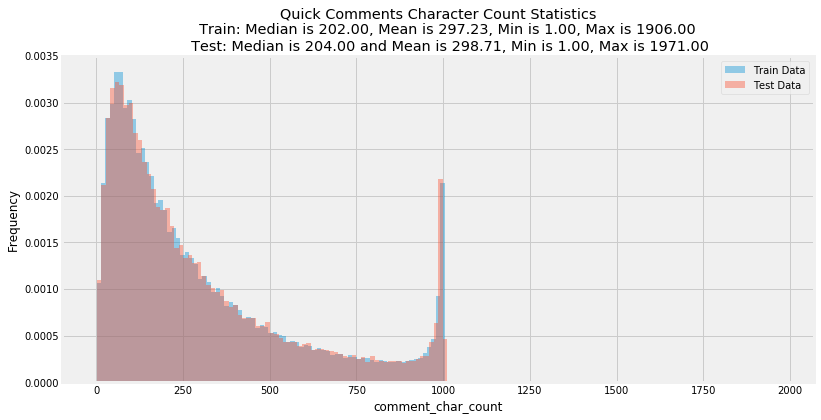

In [15]:
plt.figure(figsize=(12, 6))
sns.distplot(train_df.comment_char_count, kde=False, bins=150, label='Train Data', norm_hist=True)
sns.distplot(test_df.comment_char_count, kde=False, bins=150, label='Test Data', norm_hist=True)
plt.legend()
plt.ylabel('Frequency')
plt.title('Quick Comments Character Count Statistics\n \
    Train: Median is %.2f, Mean is %.2f, Min is %.2f, Max is %.2f \n \
    Test: Median is %.2f and Mean is %.2f, Min is %.2f, Max is %.2f' % \
          (train_df.comment_char_count.median(), train_df.comment_char_count.mean(), \
           min(train_df.comment_char_count), max(train_df.comment_char_count), \
           test_df.comment_char_count.median(), test_df.comment_char_count.mean(), \
           min(test_df.comment_char_count), max(test_df.comment_char_count)))
plt.show();

The observation of 1000 character counts comments;

- Majority (approx. 94%) are __non-toxic__ comments. 

There might be two possible explanations;

1. The commenters attempt to explain (or make themselves clear) or make a point in the comment.
2. The comments have been truncated before the toxicity is shown in the comment.

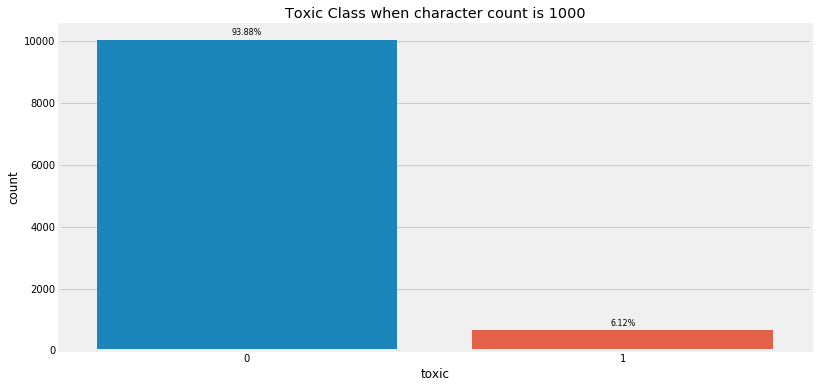

In [16]:
plt.figure(figsize=(12, 6))
_tmp = train_df[train_df['comment_char_count'] == 1000]
plot = sns.countplot(x='toxic', data=_tmp)

ax = plot.axes

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / _tmp.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
    
plt.title("Toxic Class when character count is 1000")
plt.show();

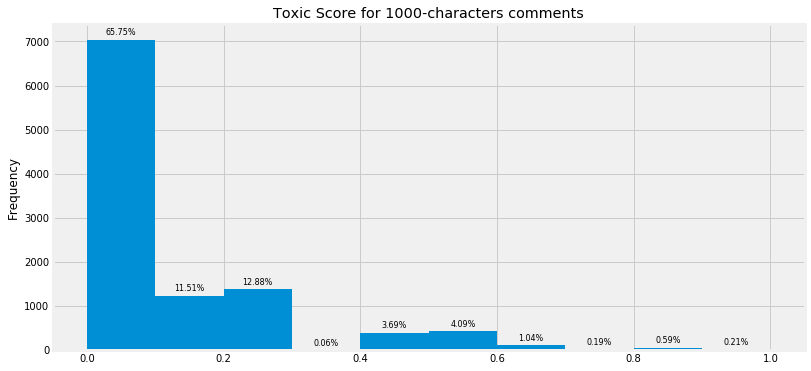

In [17]:
plt.figure(figsize=(12, 6))
plot = _tmp.target.plot(kind='hist',bins=10)
ax = plot.axes
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / _tmp.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
plt.title('Toxic Score for 1000-characters comments')
plt.show();

The below plot demonstrated the assumption that the longer comments are tended towards explanation or make a point, hence the less likely it will be __toxic__ comments.

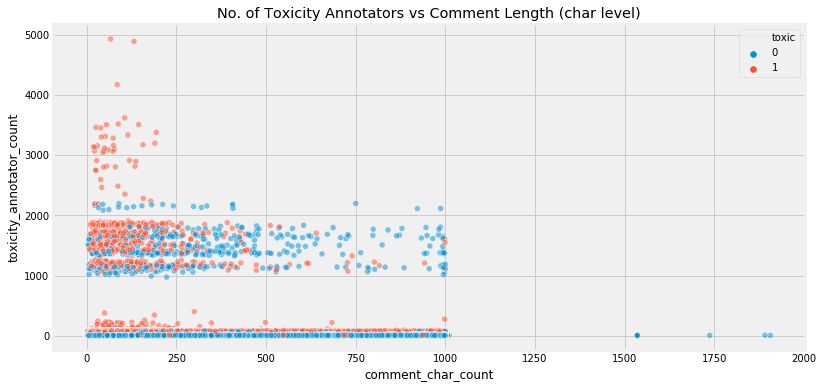

In [18]:
plt.figure(figsize=(12,6))
plot = sns.scatterplot(train_df.comment_char_count, train_df.toxicity_annotator_count, 
                       hue=train_df.toxic, alpha=.5)
plt.title('No. of Toxicity Annotators vs Comment Length (char level)')
plt.show();

The initial character count analysis provided some insights to the comments and data. Next, let's move up one level toward __word__ count, again, I will not do any preprocessing tasks to remove any punctuation and stopwords in this step.

In [19]:
train_df['comment_word_count'] = train_df.loc[:, 'comment_text'].str.split().progress_apply(len)
test_df['comment_word_count'] = test_df.loc[:, 'comment_text'].str.split().progress_apply(len)

100%|████████████████████████████████████████████████████████████████████████| 97320/97320 [00:00<00:00, 937184.26it/s]


- The word distributions are quite similar on both the train and test data sets.
- Both data sets show the __right-skewed__ behavior, due to the fact that the normal comments tend to be short.
- There are roughly 0.85% of the training comment with __only 1 word__. Let's quickly examine those comments.

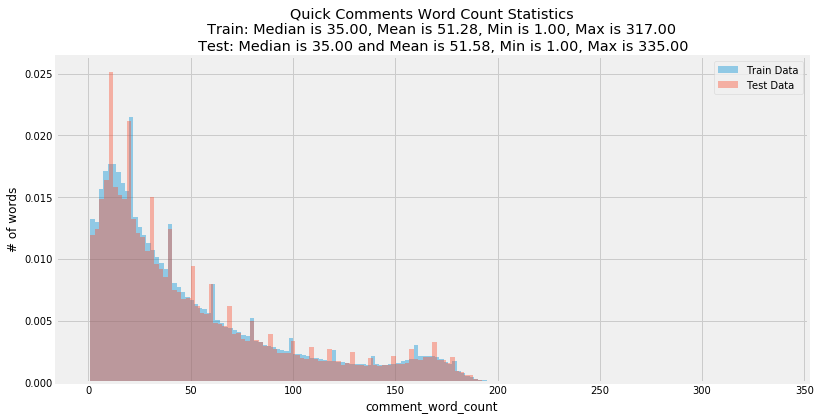

In [20]:
plt.figure(figsize=(12, 6))
sns.distplot(train_df.comment_word_count, kde=False, bins=150, label='Train Data', norm_hist=True)
sns.distplot(test_df.comment_word_count, kde=False, bins=150, label='Test Data', norm_hist=True)
plt.legend()
plt.ylabel('# of words')
plt.title('Quick Comments Word Count Statistics\n \
    Train: Median is %.2f, Mean is %.2f, Min is %.2f, Max is %.2f \n \
    Test: Median is %.2f and Mean is %.2f, Min is %.2f, Max is %.2f' % \
          (train_df.comment_word_count.median(), train_df.comment_word_count.mean(), \
           min(train_df.comment_word_count), max(train_df.comment_word_count), \
           test_df.comment_word_count.median(), test_df.comment_word_count.mean(), \
           min(test_df.comment_word_count), max(test_df.comment_word_count)))
plt.show();

In [21]:
round(train_df[train_df.comment_word_count == 1].shape[0] / train_df.shape[0] * 100, 4)

0.8527

In [22]:
round(test_df[test_df.comment_word_count == 1].shape[0] / test_df.shape[0] * 100, 4)

0.8333

By combining the `comment_word_count == 1` and mean values of `comment_char_count`

- There are actual URLs in the comment.
- Some expression words (i.e. Really?...Really?)
- The sentence is connected using underscore `_`.

Hence, we will need to handle this by removing any punctuation and separate it properly. Regarding the URL, this can be use further to classify the comment before flagging it to be toxic or non-toxic related comments.

In [23]:
train_df[(train_df.comment_word_count == 1) & \
         (train_df.comment_char_count >= train_df[(train_df.comment_word_count == 1)]. \
          comment_char_count.mean() \
         )].loc[:, ['comment_text', 'target']].tail(10)

,comment_text,target
1800328,http://www.hawaiiprepworld.com/featured/signin...,0.0
1800345,Not_if_we_are_with_the_Pope.,0.0
1800714,Agreed._The_government_cannot_force_abortion_o...,0.2
1800717,You_know_you_are_talking_to_2_different_people...,0.0
1800731,What_about_of_one_essence?_Same_as_somestance_...,0.0
1801405,http://www.doctornerdlove.com/wp-content/uploa...,0.0
1801525,http://business.financialpost.com/news/economy...,0.0
1802259,http://business.financialpost.com/commodities/...,0.0
1802473,http://www.staradvertiser.com/2017/11/09/break...,0.0
1803373,https://youtu.be/IHE17cfzyQM,0.0


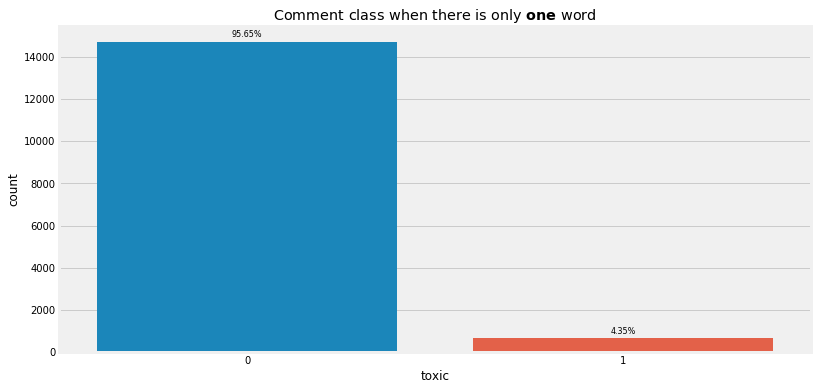

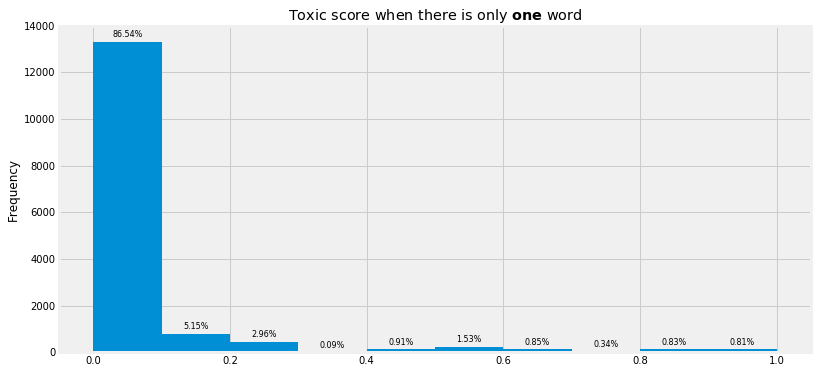

In [24]:
plt.figure(figsize=(12, 6))
_tmp = train_df[train_df['comment_word_count'] == 1]
plot = sns.countplot(x='toxic', data=_tmp)

ax = plot.axes

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / _tmp.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
    
plt.title(r"Comment class when there is only $\bf{one}$ word")
plt.show();

plt.figure(figsize=(12, 6))
plot = _tmp.target.plot(kind='hist',bins=10)
ax = plot.axes
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / _tmp.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
plt.title(r'Toxic score when there is only $\bf{one}$ word')
plt.show();

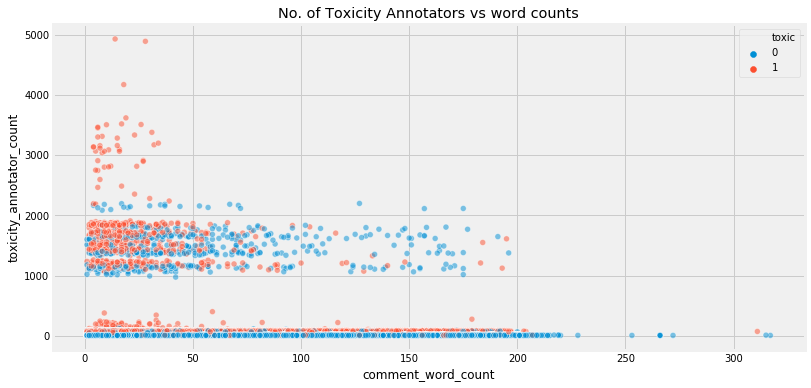

In [25]:
plt.figure(figsize=(12,6))
plot = sns.scatterplot(train_df.comment_word_count, train_df.toxicity_annotator_count, 
                       hue=train_df.toxic, alpha=.5)
plt.title('No. of Toxicity Annotators vs word counts')
plt.show();

### URL flagging

To understand more if the URL has an impact to toxic comment or not, I will add new column and flag it respectively. The function below will extract the URL from the comment string, then we will count the URL to flag it.

In [26]:
def find_url(string: str) -> list:
    """
    Function to find all the URLs in the string
    Parameters:
      string (str): The string to scan for URL
    
    Returns:
      list: The list containing the URL, can be empty list, if no URL found
    """
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url 


In [27]:
train_df['url_cnt'] = train_df.comment_text.apply(find_url).apply(len)
train_df['url_ind'] = np.where(train_df.url_cnt > 0, 1, 0)

__Summary findings__:

- Approx. 3% of total train data set contain the URL, and those 3% only 3.74% are toxic comments.
- All of the one-word URL comments are __not toxic__, as there is not much information for the reviewers to annotate the toxic behavior.
- Again, the commenters may want to prove a point or become aggressive with the use of URL to justify their opinions some samples of toxic comments are shown below.

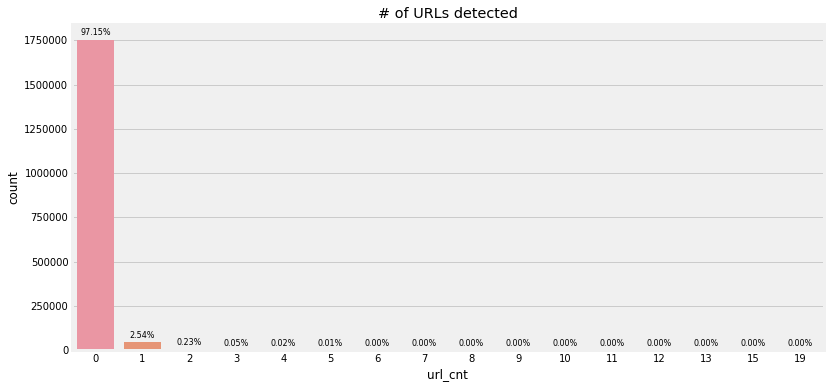

In [28]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(x='url_cnt', data=train_df)
ax = plot.axes
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / train_df.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
    
plt.title(r"# of URLs detected")
plt.show();

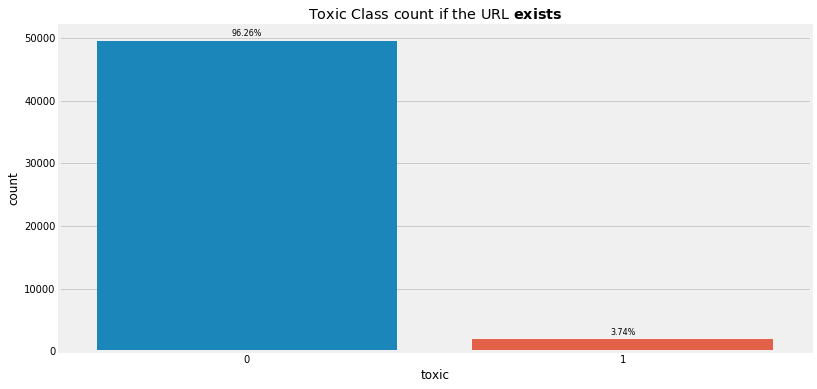

In [29]:
plt.figure(figsize=(12, 6))
_tmp = train_df[train_df.url_ind == 1]
plot = sns.countplot(x='toxic', data=_tmp)
ax = plot.axes
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / _tmp.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
    
plt.title(r"Toxic Class count if the URL $\bf{exists}$")
plt.show();

del _tmp

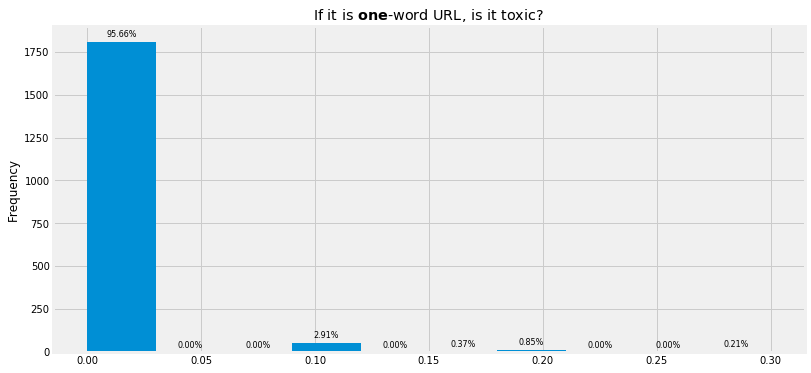

In [30]:
plt.figure(figsize=(12, 6))
plot = train_df[(train_df.url_ind == 1) & (train_df.comment_word_count == 1)].\
target.plot(kind='hist',bins=10)
ax = plot.axes
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / train_df[(train_df.url_ind == 1) & (train_df.comment_word_count == 1)].shape[0]:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')
    
plt.title(r"If it is $\bf{one}$-word URL, is it toxic?")
plt.show();

In [31]:
print("Sample Three toxic comments with URLs: \n\n%s" % '\n\n'.join(train_df[(train_df.toxic > 0) & (train_df.url_ind == 1)]. \
     comment_text.values[0: 3]))

print('\nTop Three score comments with URLs:\n\n%s' % '\n\n'.join(str(v) for v in train_df[(train_df.toxic > 0) & (train_df.url_ind == 1)].target.values[0: 3]))

Sample Three toxic comments with URLs: 

Took this as an opportunity to check back in on The Yard and the floorpans are finally up and they are ATROCIOUS.  Yeah, because I want to spend 2500+ to share a thin wall with my roommate.  Oh, and I want to pick between a dining table OR living room set, because in this modern world you can't have both.  And if you do want both, one is going to be in a tiny spot by your door and the other is going to be down a long hallway of useless square ft next to your kitchenette.  So dumb.
http://yardpdx.com/leasing/

Ladies, please don't vote with your vaginas: http://www.elephantjournal.com/2016/01/i-dont-vote-with-my-vagina-susan-sarandon-feelsthebern/

You are stating the same sort of conspiracy theory that supporters of the occupiers have been making online in countless discussion forums.   These are extremist anti-government hate groups, and are no different than Islamic terrorists with regarding to the irrationality of their thinking.   Back on Fe

<br></br>

### Pre-processing the comments

Before we are building the machine learning tasks for NLP, it is important to transform the text into something which an algorithm (or machine) can digest, analyze, and predict. Each preprocessing step for different NLP tasks will be different.

<br></br>

##### Types of text preprocessing techniques

- __Lowercasing__: one of the technique in NLP is word embedding, where words or phrases are mapped to vectors of real numbers. With different cases, the same words with different input capitalization may result in different types of mapping.
- __Stemming__: the process of reducing inflection in words to their root form (i.e. connected, connection, connects -> connect). It is useful for dealing with _sparsity issues_ as well as standardizing vocabulary. This method is also good for text retrieval (__example__: deep learning classes will be translated to 'deep learning __class__' and 'deep __learn__ classes'). Stemming only marginally helped improved classification accuracy as opposed to using better engineered features and text enrichment approaches such as using word embeddings.
- __Lemmatization__: this is similar to stemming, where the goal is to remove inflections and map a word to its root form. The only difference is that it actually transforms words to the actual roots (i.e. troubling, troubled, troubles -> trouble). It may use a dictionary such as _WordNet_ for mappings.
- __Stopword Removal__: Stop words are a set of commonly used words in a language. The inuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead. Stop words are commonly applied in search systems, text classification applications, topic modeling, topic extraction and others.
- __Normalization__: it is the process of transforming a text into a canonical (standard) form. This is very important steps for noisy texts like social media comments, text messages (example: b4 -> before, 2morro / 2mrw -> tomorrow).
- __Noise Removal__: Remove the characters digits and pieces of text that can interfere with your text analysis. This is highly ___domain dependent___. This includes punctuation removal, numbers removal, special character removal, html formatting removal, and doman specific keyword removal.
- __Text Enrichment / Augmentation__: This involves augmenting the original text data with information that you did not previously have. Text enrichment provides more semantics to the original text, thereby improving the predictive power and the depth of analysis you can perform on the data. One concept is to use _part-of-speech tagging_ to get more granular information about the words in the text.

With the above techniques, I will conduct some preprocessing to visualize the most frequent words and plotting some word clouds.

In [32]:
def remove_url(string: str, replace_to: str='<url>') -> str:
    """
    Function to find all the URLs in the string
    Parameters:
      string (str): The string to scan for URL
    
    Returns:
      list: The list containing the URL, can be empty list, if no URL found
    """
    import re
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replace_to, str(string) )
    return text 


def preprocessing_comment(comment_col: pd.core.series.Series, 
                          lower_text_flag: bool=True,
                          stop_words_remove_flag: bool=False
                         ) -> list:
    """
    Function to conduct all preprocessing on the text
    Parameters:
      comment_col (series): The text string to do pre-processing
      lower_text_flag (bool): the boolean expression to use lower the text; default is True
      stop_words_remove_flag (bool): the boolean expression to remove stop words; default is False
      
    Returns:
       list: The list of outcome text after the preprocessing
    """
    output_list = []
    for text in comment_col:
        if lower_text_flag:
            text = text.lower()
        text = re.sub('[\"!?.();:-]', '', text)
        word = text.split()
        if stop_words_remove_flag:
            word = [x for x in word if x not in gensim.parsing.preprocessing.STOPWORDS]
            word = [x for x in word if x not in wordcloud.wordcloud.STOPWORDS]
        _text = ' '.join(word)
        _text = re.sub('[^a-z]', ' ', _text)
        _text = ' '.join( [w for w in _text.split() if len(w)>1] )
        output_list.append(_text)
    return output_list


In [33]:
train_df['processed_comment'] = np.vectorize(remove_url)(train_df.comment_text, ' ')
train_df['processed_comment'] = preprocessing_comment(train_df['processed_comment'], 
                                                     stop_words_remove_flag=True)
train_df.processed_comment.head(19)

0      cool like would want mother read this great idea
1             thank life lot anxietyinducing up let way
2         urgent design problem kudos taking impressive
3                           able install site releasing
4                                haha guys bunch losers
5                                     ur sh tty comment
6                               hahahahahahahahhha suck
7                                   ffffuuuuuuuuuuuuuuu
8     ranchers motivated greed right allow animals d...
9                             great combo expected good
10                                     wow sounds great
11    great story man wonder person yelled shut fuck...
12                                 step right direction
13    ridiculous guys called protesters armed threat...
14    story gets ridiculous hour and love people sen...
15    agree want grant legitimacy protestors greedy ...
16    interesting curious works refrain commenting t...
17                          awesome love civil c

### Visualization

In this last part of the notebook, let's do some frequency distribution of the words based on toxic and non-toxic class and do some word cloud.

__Frequency count__:

- Well, no surprise, looks like the president is the major topic in the comment section.
- The word _stupid_ clearly is the toxic word as this is insulting to others.
- __$good$__ is the good representation of a non-toxic word, which can be used in sarcastic way to insult someone (based on the overall context of the sentences).
- __white__ associates mainly with toxic comment, this can related to racism comment.

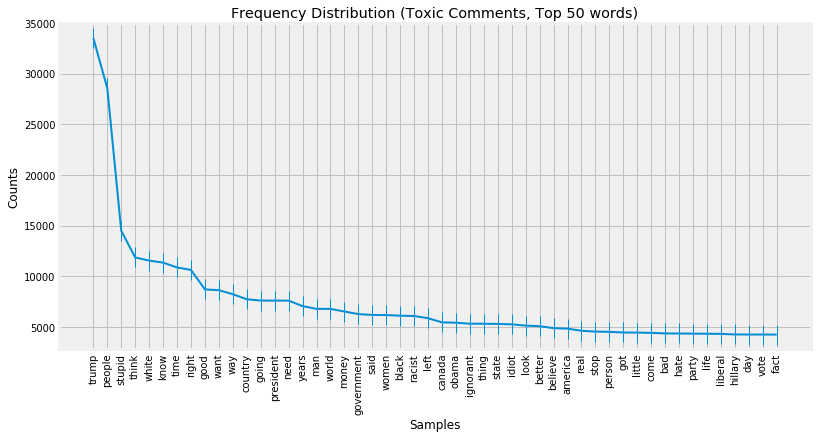

In [34]:
toxic_comments = train_df.loc[train_df['toxic'] == 1, 'processed_comment'].values
toxic_freq_dist = FreqDist([word for comment in toxic_comments for word in comment.split()])
plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Toxic Comments, Top 50 words)')
toxic_freq_dist.plot(50, marker='|', markersize=20)
plt.show()

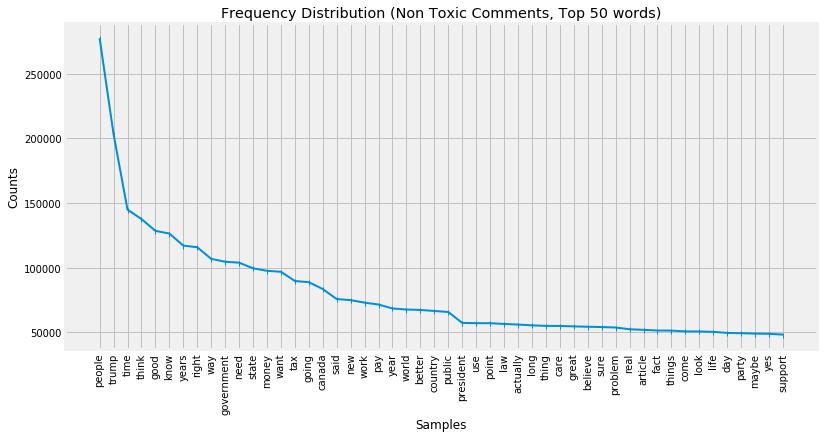

In [35]:
non_toxic_comments = train_df.loc[train_df['toxic'] == 0, 'processed_comment'].values
non_toxic_freq_dist = FreqDist([word for comment in non_toxic_comments for word in comment.split()])
plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Non Toxic Comments, Top 50 words)')
non_toxic_freq_dist.plot(50, marker='|', markersize=5)
plt.show();

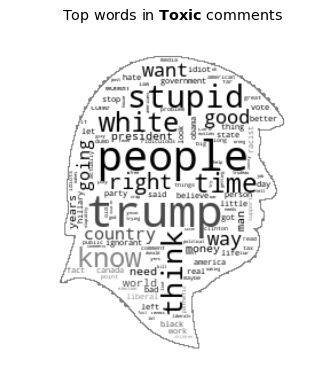

In [36]:
mask = np.array(Image.open(os.path.join(PATH, "../img/trump2.png")))
wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               contour_width=1, contour_color='grey',
               max_font_size=40, random_state=SEED)

wc.generate_from_frequencies(toxic_freq_dist)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(12, 6))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title(r"Top words in $\bf{Toxic}$ comments")
plt.show();

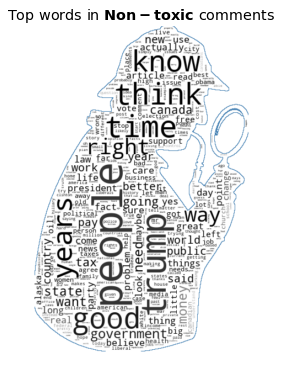

In [37]:
mask = np.array(Image.open(os.path.join(PATH, "../img/sherlock.png")))
wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               contour_width=1, contour_color='steelblue', random_state=SEED)

wc.generate_from_frequencies(non_toxic_freq_dist)
image_colors = ImageColorGenerator(mask)

plt.figure(figsize=(12,6))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title(r"Top words in $\bf{Non-toxic}$ comments")
plt.show();

### End Notes

- There are other columns, which we can use to visualize and gain an insight of the commenters (i.e. male, or comment related to homosexual topic). However, this is out of scope of the notebook and overall exercise.
- I can add some feature engineering (i.e. URL indicator) onto the data set, which can be used as predictors.
- __Preprocessing__ the text is very next importance step to create the toxic classification model.
- Properly choose __word embedding__ (build from scratch or using pre-trained) should give the edges on the model.